In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 186 GB / percent used: 26.1 %


# Check model data

In [6]:
var = 'precip'
folder = 'ATM'
exp = 'clim-without-MVA9'

# Define zone
latlim=(10,50)
lonlim=(60,110)

label, units, cmap, levels = u.get_var_infos(var)

title_1 = 'clim-def'
root_1 = '/data/mlalande/gpfsstore/rech/goe/ufz23bm/IGCM_OUT/LMDZOR/PROD/clim'

title_2 = 'clim-without-MVA9'
root_2 = '/data/mlalande/gpfsstore/rech/goe/ufz23bm/IGCM_OUT/LMDZOR_v6.1.11_without_elevation_average/PROD/clim'

## Define paths and period

In [7]:
path_1 = root_1+'/clim-relief-def/'+folder+'/Analyse/TS_MO'
xr.open_mfdataset(path_1+'/*'+var+'.nc', combine='by_coords').time_counter.coords

Coordinates:
  * time_counter   (time_counter) object 1980-01-16 00:00:00 ... 1991-12-16 00:00:00
    time_centered  (time_counter) object dask.array<chunksize=(144,), meta=np.ndarray>

In [8]:
path_2 = root_2+'/clim-relief-def/'+folder+'/Analyse/TS_MO'
xr.open_mfdataset(path_2+'/*'+var+'.nc', combine='by_coords').time_counter.coords

Coordinates:
  * time_counter   (time_counter) object 1980-01-16 00:00:00 ... 1989-12-16 00:00:00
    time_centered  (time_counter) object dask.array<chunksize=(120,), meta=np.ndarray>

In [9]:
# Here the time doesn't make so much sense because the simulation are clim
period = slice('1982','1989')

## Load climatologies

In [10]:
model_1_clim = xr.open_mfdataset(path_1+'/*'+var+'.nc', combine='by_coords'
                                )[var].sel(time_counter=period).mean('time_counter')*86400
model_1_clim.load()

<xarray.DataArray 'precip' (lat: 143, lon: 144)>
array([[0.27368582, 0.27368582, 0.27368582, ..., 0.27368582, 0.27368582,
        0.27368582],
       [0.63786473, 0.62553363, 0.63732991, ..., 0.62892559, 0.6200743 ,
        0.6299799 ],
       [0.67539089, 0.67315324, 0.67525165, ..., 0.69208733, 0.68090676,
        0.67359722],
       ...,
       [0.15676487, 0.2505336 , 0.36902433, ..., 0.15650946, 0.19072152,
        0.16519468],
       [0.15783458, 0.14812333, 0.13423419, ..., 0.1632083 , 0.15927647,
        0.15197824],
       [0.08180893, 0.08180893, 0.08180893, ..., 0.08180893, 0.08180893,
        0.08180893]])
Coordinates:
  * lat      (lat) float32 90.0 88.73239 87.46479 ... -87.46479 -88.73239 -90.0
  * lon      (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5

In [11]:
model_2_clim = xr.open_mfdataset(path_2+'/*'+var+'.nc', combine='by_coords'
                                )[var].sel(time_counter=period).mean('time_counter')*86400
model_2_clim.load()

<xarray.DataArray 'precip' (lat: 143, lon: 144)>
array([[0.26930939, 0.26930939, 0.26930939, ..., 0.26930939, 0.26930939,
        0.26930939],
       [0.65540111, 0.63221433, 0.65314676, ..., 0.76584787, 0.74379209,
        0.7509    ],
       [0.624251  , 0.62249697, 0.6345983 , ..., 0.6550699 , 0.6503792 ,
        0.64724459],
       ...,
       [0.16188636, 0.26424787, 0.38669288, ..., 0.16515614, 0.18361743,
        0.16115426],
       [0.16646301, 0.16061269, 0.13659817, ..., 0.14663956, 0.14336996,
        0.14909584],
       [0.08112343, 0.08112343, 0.08112343, ..., 0.08112343, 0.08112343,
        0.08112343]])
Coordinates:
  * lat      (lat) float32 90.0 88.73239 87.46479 ... -87.46479 -88.73239 -90.0
  * lon      (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5

# Load obs
## APHRODITE http://aphrodite.st.hirosaki-u.ac.jp/download/data/search/  
http://aphrodite.st.hirosaki-u.ac.jp/download/
V1101 et V1101EX_R1 domain MA

http://localhost:7227/notebooks/notebooks/CICLAD/Himalaya/CMIP6_IPSL_bias/Precipitation.ipynb

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


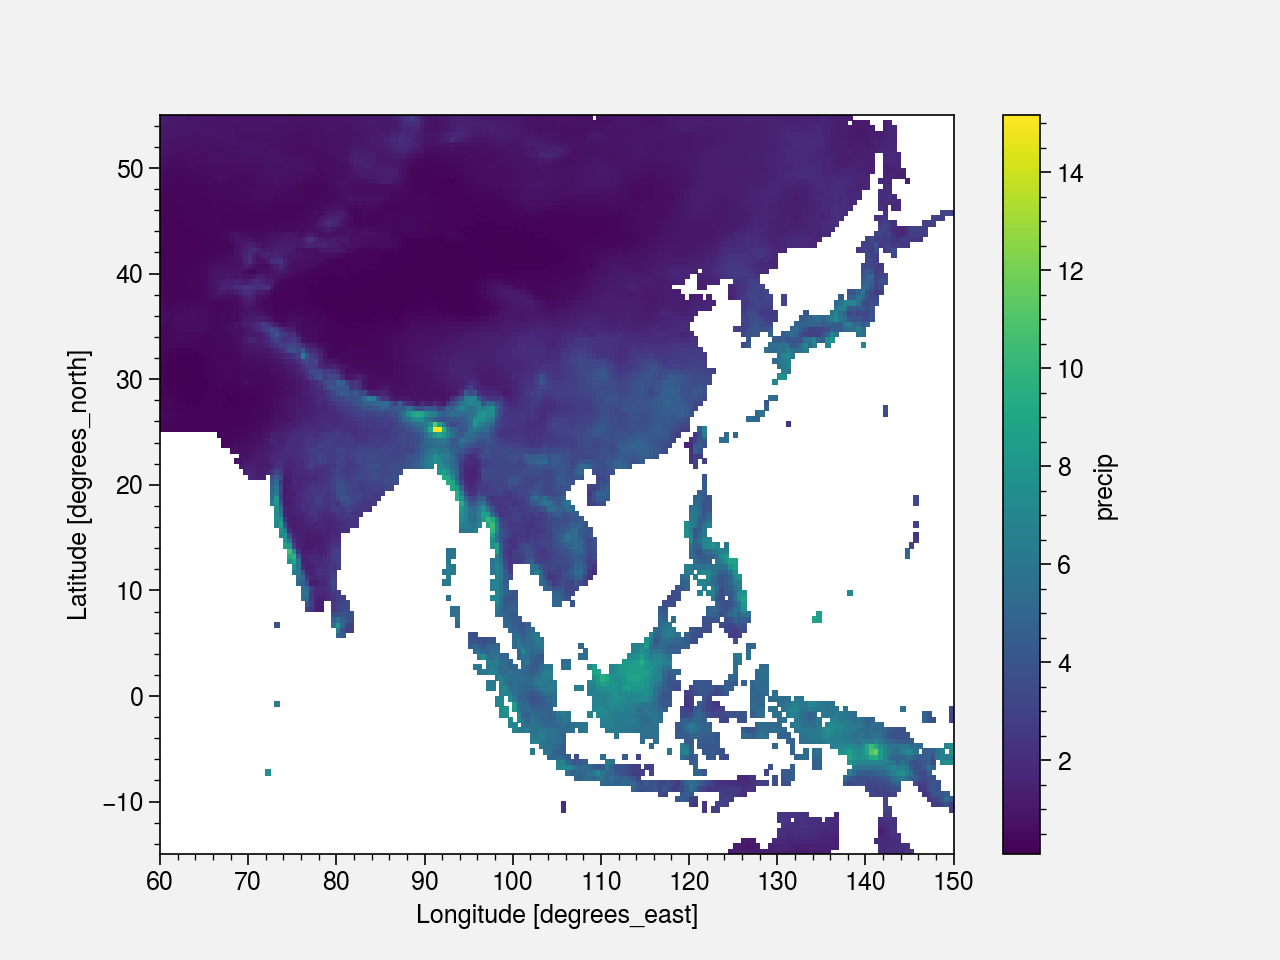

In [12]:
obs_longname = 'APHRODITE V1101 (0.5°)'
obs_name = 'APHRODITE'

obs_V1101 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101.*.nc', combine='by_coords'
).precip
obs_V1101_EXR1 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101_EXR1.*.nc', combine='by_coords'
).precip

obs_V1101 = obs_V1101.rename({'longitude': 'lon', 'latitude': 'lat'})
obs = xr.combine_nested([obs_V1101, obs_V1101_EXR1], concat_dim='time')
# Daily donc pas besoin de faire la clim en prenant en compte le nb de jours dans le mois
obs_clim = obs.sel(time=period).mean('time')
obs_clim.plot()

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/) 

In [13]:
# For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
import scipy
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

regridder_obs = xe.Regridder(obs_clim, model_1_clim, 'bilinear', periodic=False, reuse_weights=True)
regridder_obs = add_matrix_NaNs(regridder_obs)
obs_clim_regrid = regridder_obs(obs_clim)

Create weight file: bilinear_140x180_143x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


# Plot differences

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


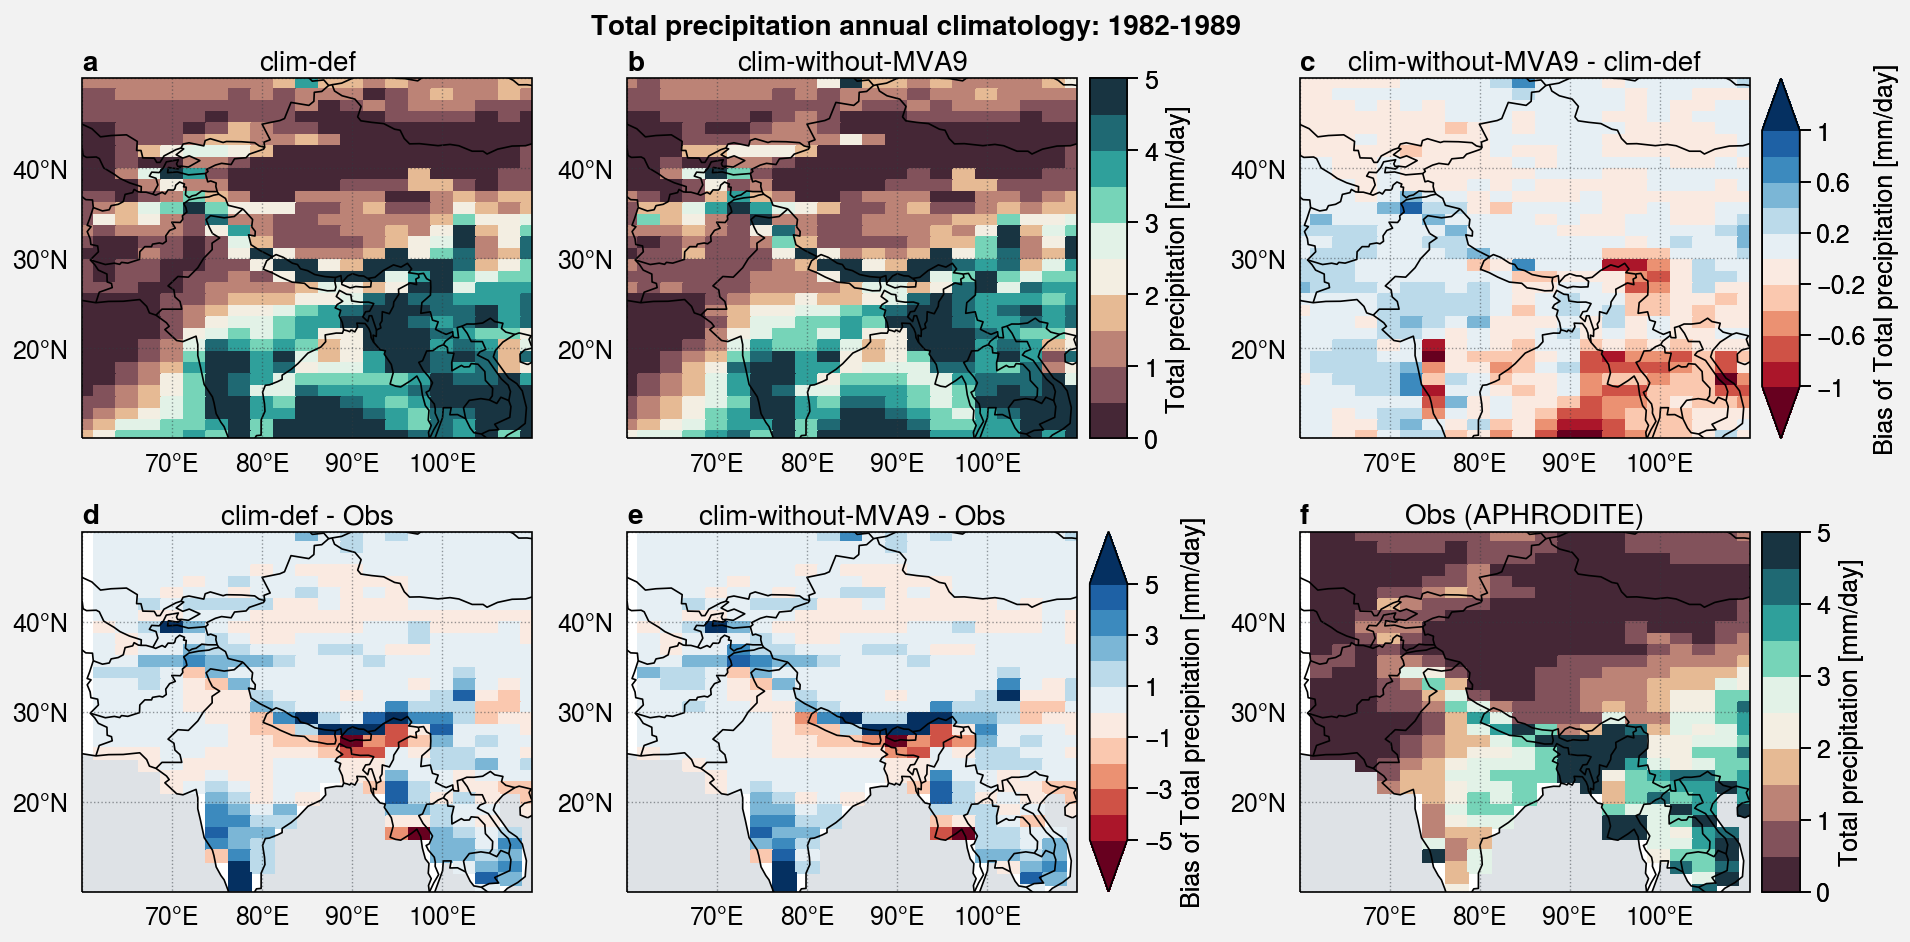

In [16]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=2)

levels_diff = plot.arange(-1,1,0.2)
cmap_diff = 'BuRd_r'
extend_diff = 'both'

levels_bias = plot.arange(-5,5,1)
cmap_bias = 'BuRd_r'
extend_bias = 'both'

# First row: differences
axs[0].pcolormesh(model_1_clim, cmap=cmap, levels=levels)
axs[0].format(title=title_1)

m1 = axs[1].pcolormesh(model_2_clim, cmap=cmap, levels=levels)
axs[1].format(title=title_2)
axs[1].colorbar(m1, label=label+ ' ['+units+']')

m2 = axs[2].pcolormesh(model_2_clim - model_1_clim, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[2].format(title=title_2+' - '+title_1)
axs[2].colorbar(m2, label='Bias of '+label+ ' ['+units+']')


# Second row: bias with obs

m3 = axs[3].pcolormesh(model_1_clim - obs_clim_regrid, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
axs[3].format(title=title_1+' - Obs')

axs[4].pcolormesh(model_2_clim - obs_clim_regrid, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
axs[4].format(title=title_2+' - Obs')
axs[4].colorbar(m3, label='Bias of '+label+ ' ['+units+']')

axs[5].pcolormesh(obs_clim_regrid, cmap=cmap, levels=levels)
axs[5].format(title='Obs ('+obs_name+')')
axs[5].colorbar(m1, label=label+ ' ['+units+']')


axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle=label+" annual climatology: "+period.start+"-"+period.stop,
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

# f.save('img/'+var+'_'+exp+'_'+period.start+'-'+period.stop+'.jpg')
# f.save('img/'+var+'_'+exp+'_'+period.start+'-'+period.stop+'.png')
# f.save('img/'+var+'_'+exp+'_'+period.start+'-'+period.stop+'.pdf')

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


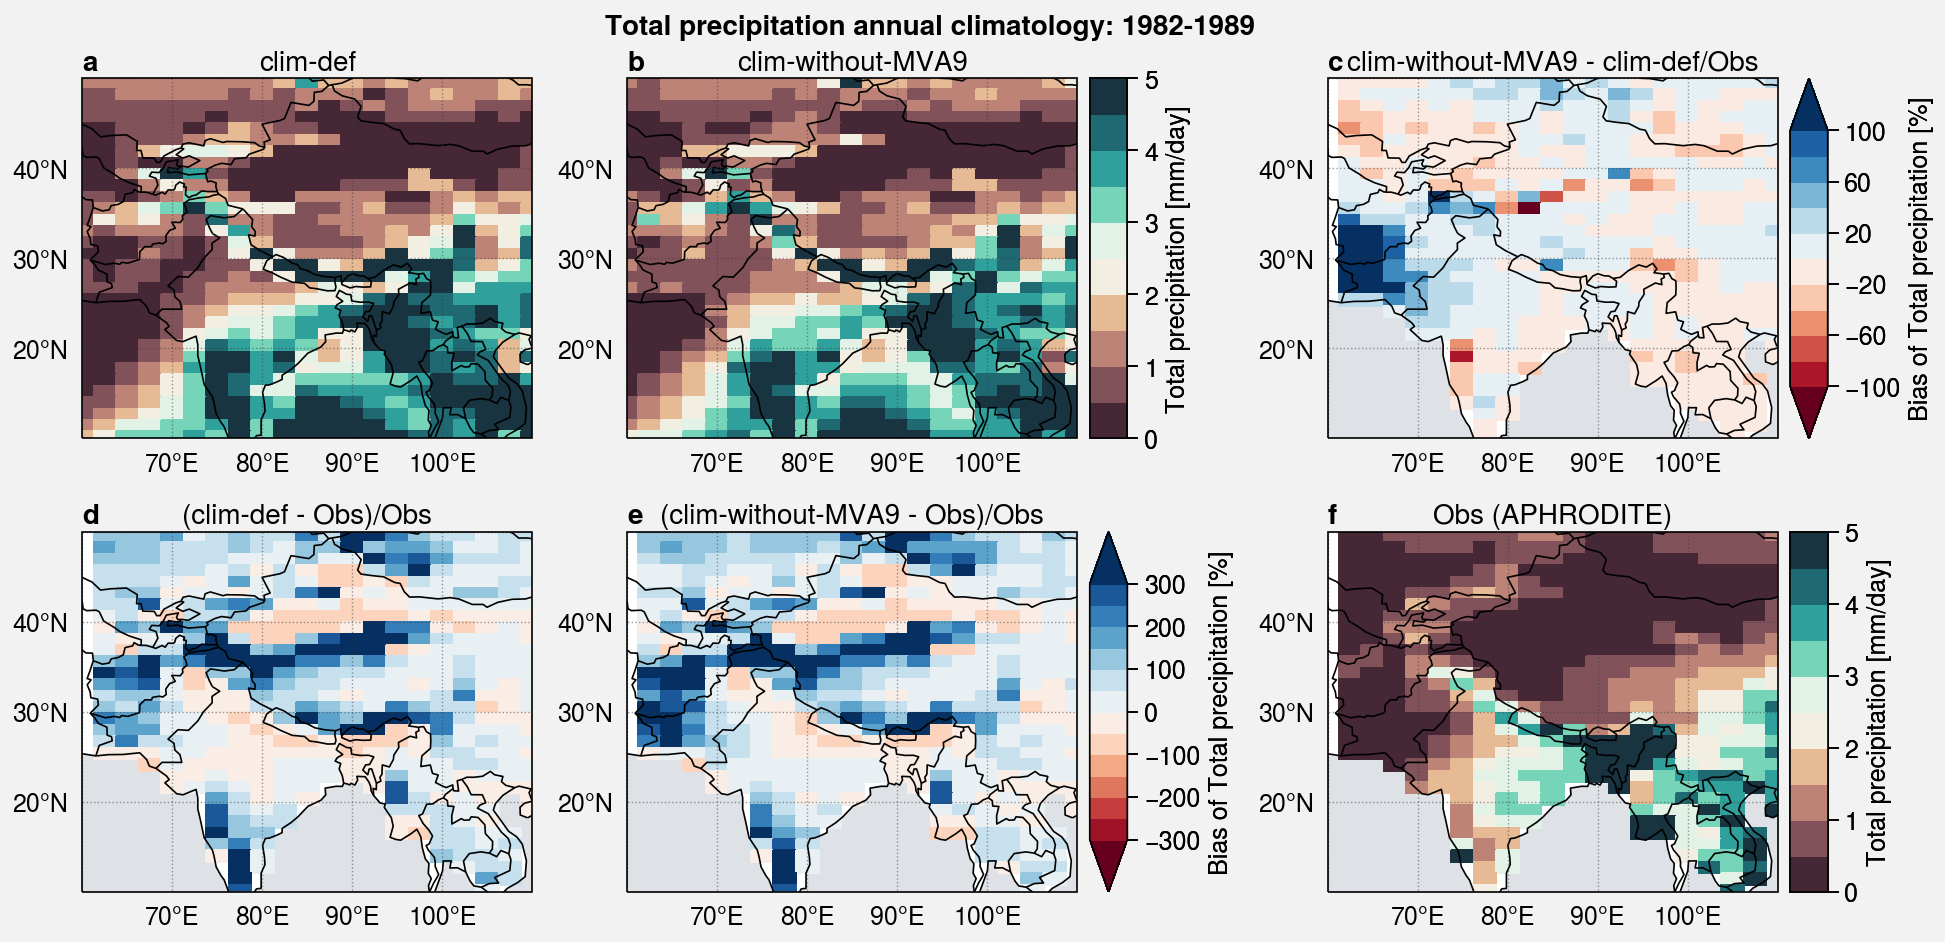

In [17]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=2)

levels_diff = plot.arange(-100,100,20)
cmap_diff = 'BuRd_r'
extend_diff = 'both'

levels_bias = plot.arange(-300,300,50)
cmap_bias = 'BuRd_r'
extend_bias = 'both'

# First row: differences
axs[0].pcolormesh(model_1_clim, cmap=cmap, levels=levels)
axs[0].format(title=title_1)

m1 = axs[1].pcolormesh(model_2_clim, cmap=cmap, levels=levels)
axs[1].format(title=title_2)
axs[1].colorbar(m1, label=label+ ' ['+units+']')

m2 = axs[2].pcolormesh((model_2_clim - model_1_clim)/obs_clim_regrid*100, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[2].format(title=title_2+' - '+title_1+'/Obs')
axs[2].colorbar(m2, label='Bias of '+label+ ' [%]')

# Second row: bias with obs

m3 = axs[3].pcolormesh((model_1_clim - obs_clim_regrid)/obs_clim_regrid*100, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
axs[3].format(title='('+title_1+' - Obs)/Obs')

axs[4].pcolormesh((model_2_clim - obs_clim_regrid)/obs_clim_regrid*100, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
axs[4].format(title='('+title_2+' - Obs)/Obs')
axs[4].colorbar(m3, label='Bias of '+label+ ' [%]')

axs[5].pcolormesh(obs_clim_regrid, cmap=cmap, levels=levels)
axs[5].format(title='Obs ('+obs_name+')')
axs[5].colorbar(m1, label=label+ ' ['+units+']')


axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle=label+" annual climatology: "+period.start+"-"+period.stop,
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

# f.save('img/'+var+'_relative_'+exp+'_'+period.start+'-'+period.stop+'.jpg')
# f.save('img/'+var+'_relative_'+exp+'_'+period.start+'-'+period.stop+'.png')
# f.save('img/'+var+'_relative_'+exp+'_'+period.start+'-'+period.stop+'.pdf')